# Wikipedia recommender system

* Oskar Szudzik 148245
* Krystian Moras 148243

First we need to scrape and preprocess articles from wikipedia.

In [220]:
import wikipedia

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize

porter = PorterStemmer()
wordnet = WordNetLemmatizer()
COLUMNS = ["title","summary","links","categories","references"] # todo: add sections

def download_article():
    try:
        return wikipedia.page(title=wikipedia.random(1))
    except: # sometimes the package can't find the article but the title is a random title from the list of articles
        return download_article()


def preprocess_article(article):

    title = article.title
    summary = wordnet.lemmatize(porter.stem(article.summary))
    categories = "|".join(article.categories)
    links = "|".join(article.links)
    try:
        references = "|".join(article.references)
    except KeyError:
        references = ""
    return title,summary,links,categories,references
def save_article(title,summary,links,categories,references):
    try:
        df = pd.read_csv(open("wikipedia.csv",encoding="utf-8"),encoding_errors='ignore').set_index("title")
        df.loc[title] = (summary,links,categories,references)
    except pd.errors.EmptyDataError as e:
        preprocessed_dict = {"title":title,"summary":summary,"links":links,"categories":categories,"references":references}
        df = pd.DataFrame.from_records([preprocessed_dict],index="title")
    # We append the articles one by one in case there is an error, 
    df.to_csv(open("wikipedia.csv",mode="w",encoding="utf-8"))

Download the articles and put them to wikipedia.csv file

In [221]:
for i in range(10):
    article = download_article()
    print(article.title)
    title,summary,links,categories,references = preprocess_article(article)
    save_article(title,summary,links,categories,references)

Slevin's mouse
Sam Kutesa
Jennifer Siebel Newsom
Photo response non-uniformity
Banksia dallanneyi var. dallanneyi
Tudor Vladimirescu National College
Jimmy Flint
The Remixes – Volume 2
Saheb Bahadur
DJ Mog


## Dataset statistics

In [3]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [197]:
data = pd.read_csv('wikipedia.csv', header=0)
data.head()

,title,summary,links,categories,references
0,Psilocybe yungensis,psilocybe yungensis is a species of psychedeli...,Agaricales|Agaricomycetes|Alexander H. Smith|A...,Articles with 'species' microformats|Articles ...,http://www.fungimag.com/summer-2011-articles/F...
1,"Mian Rud, South Khorasan","mian rud (persian: ميان رود, also romanized as...","Abbasabad, Doreh|Abbasabad, Momenabad|Administ...",All stub articles|Articles containing Persian-...,http://geonames.nga.mil/namesgaz/|http://geoha...
2,Coat of arms of Hesse,the coat of arms of the german state of hesse...,Armiger|Blazon|Coat of arms|Coat of arms of An...,All stub articles|Articles with short descript...,https://www.hessen.de/fuer-besucher/70-jahre-h...
3,Helsinki Police Department,the helsinki police department (hpd) (finnish:...,2018 Russia–United States summit|8th World Fes...,Government agencies established in 1826|Law en...,http://tass.com/politics/1013215/amp|https://b...
4,Broadway Stages,"broadway stages, ltd. is one of new york’s ful...","Annadale, Staten Island|Arden Heights, Staten ...",1983 establishments in New York City|American ...,http://Broadway-Stages.com/|http://www.broadwa...


Most common words in the whole dataset

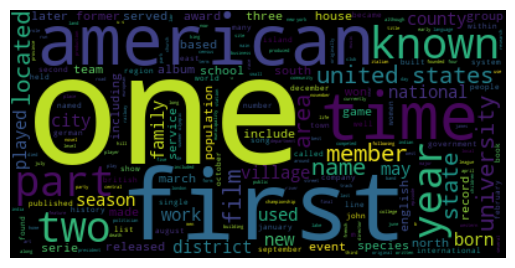

In [198]:
import matplotlib.pyplot as plt
# Start with one review:
text = " ".join(data.summary)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Categories and their counts

In [199]:
import numpy as np

categories = data['categories'].str.split('|')
categories = categories.explode()
val_counts = categories.value_counts()

val_counts = val_counts[:25]
print(val_counts.to_markdown())

|                                              |   categories |
|:---------------------------------------------|-------------:|
| Articles with short description              |         1309 |
| Short description is different from Wikidata |          826 |
| All stub articles                            |          619 |
| Short description matches Wikidata           |          514 |
| Living people                                |          318 |
| Coordinates on Wikidata                      |          316 |
| Articles with VIAF identifiers               |          286 |
| Articles with WORLDCATID identifiers         |          231 |
| Articles with LCCN identifiers               |          216 |
| AC with 0 elements                           |          214 |
| Articles with hCards                         |          178 |
| Articles with ISNI identifiers               |          172 |
| All articles with unsourced statements       |          145 |
| Articles with GND identifiers         

We will perform TF-IDF for summary of articles. To later propose similar articles to ones liked by a client.

In [147]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from scipy.spatial.distance import cosine

In [148]:
article = data.iloc[0]
article.summary

'psilocybe yungensis is a species of psychedelic mushroom in the family hymenogastraceae. in north america, it is found in northeast, central and southeastern mexico. in south america, it has been recorded from bolivia, colombia, and ecuador. it is also known from the caribbean island martinique, and china. the mushroom grows in clusters or groups on rotting wood. the fruit bodies have conical to bell-shaped reddish- to orangish-brown caps that are up to 2.5 cm (1.0 in) in diameter, set atop slender stems 3 to 5 cm (1.2 to 2.0 in) long. the mushrooms stain blue when bruised, indicative of the presence of the compound psilocybin. psilocybe yungensis is used by mazatec indians in the mexican state of oaxaca for entheogenic purposes.'

In [200]:
articles = np.array(data.title)

summaries = np.array(data.summary)
summaries[:2]

array(['psilocybe yungensis is a species of psychedelic mushroom in the family hymenogastraceae. in north america, it is found in northeast, central and southeastern mexico. in south america, it has been recorded from bolivia, colombia, and ecuador. it is also known from the caribbean island martinique, and china. the mushroom grows in clusters or groups on rotting wood. the fruit bodies have conical to bell-shaped reddish- to orangish-brown caps that are up to 2.5 cm (1.0 in) in diameter, set atop slender stems 3 to 5 cm (1.2 to 2.0 in) long. the mushrooms stain blue when bruised, indicative of the presence of the compound psilocybin. psilocybe yungensis is used by mazatec indians in the mexican state of oaxaca for entheogenic purposes.',
       'mian rud (persian: ميان رود, also romanized as mīān rūd, meyan rūd, and miyan rood; also known as kalāteh miyānrūd and kalāteh-ye mīān rūd) is a village in naharjan rural district, mud district, sarbisheh county, south khorasan province, iran

In [201]:
tfidf=TfidfVectorizer(stop_words='english',use_idf=True, smooth_idf=False) 
 
dfTFIDF = pd.DataFrame(tfidf.fit_transform(summaries).toarray(), index=articles, columns=tfidf.get_feature_names_out())
dfTFIDF.head()

,00,000,001,008,01,016,027,03,04,041,...,龍馬,김용국,대한민국,백학순,보았다,세종연구소,악마를,윤동헌,윤원일,해병대
Psilocybe yungensis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Mian Rud, South Khorasan",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Coat of arms of Hesse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Helsinki Police Department,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Broadway Stages,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
query = "Helsinki Police Department"
mask = data['title'] == query
pos = np.flatnonzero(mask)
query_summary = data.iloc[3].summary

query = tfidf.transform([query_summary]).toarray()[0] 
results = 1-dfTFIDF.apply(lambda x: cosine(x, query), axis=1).sort_values()[:5]
results

Helsinki Police Department              1.000000
William Stephen Devery                  0.205127
Los Angeles Police Protective League    0.120018
Rita Polster                            0.114651
Old Police Headquarters                 0.112979
dtype: float64

Okay, but we would like to apply it to a list of liked articles.

First download the articles if they are not already in the database

In [203]:
liked_articles = ["Poland (country)", "China (country)","Sweden (country)"]

recalculate = False
for i,l_article in enumerate(liked_articles):   
    if l_article not in data['title']:
        recalculate = True
        title,summary,links,categories,references = preprocess_article(wikipedia.page(title=l_article))
        liked_articles[i] = title
        data.loc[len(data.index)] = (title,summary,links,categories,references)
if recalculate:
    articles = np.array(data.title)
    summaries = np.array(data.summary)
    dfTFIDF = pd.DataFrame(tfidf.fit_transform(summaries).toarray(), index=articles, columns=tfidf.get_feature_names_out())
print(liked_articles)

['Poland', 'China', 'Sweden']


In [204]:

scores = {}
for l_article in liked_articles:
    mask = data['title'] == l_article
    pos = np.flatnonzero(mask)
    query_summary = data.iloc[pos[0]].summary

    query = tfidf.transform([query_summary]).toarray()[0] 
    score_board = 1 - dfTFIDF.apply(lambda x: cosine(x, query), axis=1)
    for article in score_board.keys():
        if article in scores.keys():
            scores[article] += score_board[article] / len(liked_articles)
        else:
            scores[article] = score_board[article] / len(liked_articles)

sorted_scores = {k: v for k, v in sorted(score_board.items(), key=lambda item: -item[1])}
for l_article in liked_articles:
    sorted_scores.pop(l_article)
sorted_scores



Poland
China
Sweden


{'2002 IIHF World Championship rosters': 0.24794178158660285,
 'Sinikka Bohlin': 0.2071624846048632,
 'Estonia': 0.20272409790445645,
 'Stenshuvud National Park': 0.13936276253103774,
 'Höglekardalen': 0.11996794646952424,
 'Social determinants of health in poverty': 0.09307619881980655,
 'IFK Rättvik': 0.09030509664483,
 'Lars Mejern Larsson': 0.08512356161501011,
 'House of Munsö': 0.08315843256628586,
 'Andreas Landgren': 0.08219240641161196,
 'Karin Svingstedt': 0.07803207952131919,
 'American Country Awards': 0.07135817727723281,
 '2009 Palmer Cup': 0.06931671791910055,
 'State aid (European Union)': 0.06889748820976527,
 'Gmina Jedlicze': 0.06793337262531829,
 'Helsinki Police Department': 0.0646080277454133,
 'National Archives of Guinea': 0.06300049861520396,
 'Medicine in Azerbaijan': 0.06062488779336772,
 'Eurasian eagle-owl': 0.0597262513606307,
 'Innocenzo Chatrian': 0.059522358880574,
 "Atria Institute on gender equality and women's history": 0.05660538960946759,
 'Industr

## Explainability

To show what words had the most impact on the results we will highlight them the brighter the value, the more important the word

In [222]:
import random
from IPython.display import display, HTML

import matplotlib.cm as cm
from matplotlib.colors import Normalize

def calculate_word_color_map(importance):
    cmap = cm.get_cmap("plasma")
    values = np.array(list(importance.values()))

    norm = Normalize(vmin=values.min(), vmax=values.max())
    rgba_values = cmap(norm(values))


    return {word:f"rgba({rgba_values[i][0]*255},{rgba_values[i][1]*255},{rgba_values[i][2]*255},{rgba_values[i][3]})" for i,word in enumerate(importance.keys())}

def highlighter(word,word_color):
    if word not in word_color:
        return word
    color = word_color[word]
    word = '<span style="background-color:' +color+ '">' +word+ '</span>'
    return word



def display_importance(title1,title2):
    
    summary1 = data.loc[data.title == title1].summary.item()
    summary2 = data.loc[data.title == title2].summary.item()


    tfidf1 = tfidf.transform([summary1]).toarray()[0]
    tfidf2 = tfidf.transform([summary2]).toarray()[0] 

    importance = tfidf1*tfidf2

    indices = list(range(len(tfidf1)))
    most_contributing = sorted(zip(indices,importance), key=lambda i:i[1],reverse=True)
    importance = {dfTFIDF.columns[i[0]]:i[1] for i in most_contributing if i[1]>0}

    word_color = calculate_word_color_map(importance)

    text1 = ' '.join([highlighter(word,word_color) for word in summary1.split()])
    display(HTML(text1))

for article in liked_articles:
    display_importance(article,list(sorted_scores.keys())[0])
